## Advanced Machine Learning - Non-negative Matrix Factorization

------------------------------------------------------------------------

-   Load Data.
    -   ORL dataset.
    -   Extended YaleB dataset.
    -   AR dataset.
-   Perform Evaluation.
    -   Relative Reconstruction Errors.
    -   Accuracy, NMI.

**Note: All datasets can be used only for this assignment and you are
not allowed to distribute these datasets. If you want to use AR dataset,
you need to apply it by yourself (we do not provide AR dataset due to
the problem of license, please find more details in
<http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html>).**

## 1. Load Dataset

### 1.0 Data Folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# The structure of data folder.
!ls -l "/content/drive/MyDrive/5328team"

ls: /content/drive/MyDrive/5328team: No such file or directory
lrw------- 1 root root 0 Sep 19 03:21 /content/drive/MyDrive/5328team -> /content/drive/.shortcut-targets-by-id/1qAJjXVkm72Bl409ZicKXIreHvYg7gjqI/5328team


The block were used to quickly loading datasets. Normally, you should use load_data function and load_data_AR function

In [ ]:
# save dataset
##ORL
# with open('/content/drive/MyDrive/5328team/ORL_dataset.npy', 'wb') as f:
#     np.save(f, ORL_X)
#     np.save(f, ORL_Y)
#     np.save(f, IMAGE_SHAPE["ORL"])
# ##EYB
# with open('/content/drive/MyDrive/5328team/EYB_dataset.npy', 'wb') as f:
#     np.save(f, EYB_X)
#     np.save(f, EYB_Y)
#     np.save(f, IMAGE_SHAPE["EYB"])
# ##AR
# with open('/content/drive/MyDrive/5328team/AR_dataset.npy', 'wb') as f:
#     np.save(f, AR_X)
#     np.save(f, AR_Y)
#     np.save(f, IMAGE_SHAPE["AR"])


# #load dataset
# ##ORL
# import numpy as np
# IMAGE_SHAPE = {}
# with open('/content/drive/MyDrive/5328team/ORL_dataset.npy', 'rb') as f:
#     ORL_X = np.load(f)
#     ORL_Y = np.load(f)
#     IMAGE_SHAPE["ORL"] = np.load(f)
# ##EYB
# with open('/content/drive/MyDrive/5328team/EYB_dataset.npy', 'rb') as f:
#     EYB_X = np.load(f)
#     EYB_Y = np.load(f)
#     IMAGE_SHAPE["EYB"] = np.load(f)
# ##AR
# with open('/content/drive/MyDrive/5328team/AR_dataset.npy', 'rb') as f:
#     AR_X = np.load(f)
#     AR_Y = np.load(f)
#     IMAGE_SHAPE["AR"] = np.load(f)


\# Tree structure of data folder. ├── CroppedAR ├── M-001-01.bmp ├──
M-001-01.txt ├── M-001-02.bmp ├── M-001-02.txt ├── ... ├── CroppedYaleB
│ ├── yaleB01 │ ├── yaleB02 │ ... │ ├── yaleB38 │ └── yaleB39 └── ORL
├── s1 ├── s2 ├── s3 ├── ... ├── s40

### 1.1 Load ORL Dataset and Extended YaleB Dataset.

-   ORL dataset contains ten different images of each of 40 distinct
    subjects. For some subjects, the images were taken at different
    times, varying the lighting, facial expressions (open / closed eyes,
    smiling / not smiling) and facial details (glasses / no glasses).
    All the images were taken against a dark homogeneous background with
    the subjects in an upright, frontal position (with tolerance for
    some side movement). The size of each image is 92x112 pixels, with
    256 grey levels per pixel. To further reduce the computation
    complexity, you can resize all images to 30x37 pixels.

-   Extended YaleB dataset contains 2414 images of 38 human subjects
    under 9 poses and 64 illumination conditions. All images are
    manually aligned, cropped, and then resized to 168x192 pixels. To
    further reduce the computation complexity, you can resize all images
    to 42x48 pixels.

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
SEED = 1
rng = np.random.RandomState(SEED)

In [ ]:
def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])
            img_size = np.array(img.size)

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    # normalization
    images = images/255
    return images, labels, img_size

In [ ]:
# Load Extended ORL dataset 
IMAGE_SHAPE = {}

ORL_X, ORL_Y, IMAGE_SHAPE["ORL"] = load_data(root='/content/drive/MyDrive/5328team/data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(ORL_X.shape, ORL_Y.shape))

# Load Extended YaleB dataset 
EYB_X, EYB_Y, IMAGE_SHAPE["EYB"] = load_data(root='/content/drive/MyDrive/5328team/data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(EYB_X.shape, EYB_Y.shape))

In [ ]:
print('Image in ORL dataset: Image.shape = {}'.format(IMAGE_SHAPE["ORL"]))
print('Image in EYB dataset: Image.shape = {}'.format(IMAGE_SHAPE["EYB"]))


### 1.2 Load AR Dataset (Optional)

AR dataset contains 2600 images of 100 individuals (50 male and 50
female). All images have been cropped and resized to 120x165 pixels. To
further reduce the computation complexity, you can resize all images to
40x55 pixels.

In [ ]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """ 
    Load AR dataset to numpy array.
    
    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []
    
    for fname in os.listdir(root):
        
        if not fname.endswith('.bmp'):
            continue
        
        # get label.
        label = int(fname[2:5])
        if fname[0] == 'W': # start from 50
            label += 50
        
        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey
        # print(img.size) ##(120,165)
        
        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])
        img_size = np.array(img.size)
        # print(img.size) ##(40,55)
        # print(img_size) ##(40,55)

        # TODO: preprocessing.
        
        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))
        # print(img.shape) ##(2200,1) #2200=40*55
        
        # collect data and label.
        images.append(img)
        labels.append(label)
        
    # concate all images and labels.
    # print(images[:1])
    images = np.concatenate(images, axis=1)
    # print(images.shape) ##(2200,2600) 2200 pixels per image; 2600 images in total
    labels = np.array(labels)
    
    # normalization
    images = images/255
    return images, labels, img_size


In [ ]:
AR_X, AR_Y, IMAGE_SHAPE["AR"] = load_data_AR(root='/content/drive/MyDrive/5328team/data/CroppedAR/test2', reduce=3)

In [ ]:
print('AR dataset: X.shape = {}, Y.shape = {}'.format(AR_X.shape, AR_Y.shape))
print('Image in AR dataset: Image.shape = {}'.format(IMAGE_SHAPE["AR"]))

## 2. NMF Algorithms
L2_norm NMF, L1_norm robust NMF and Hypersurface cost NMF are implemented and used in the project. 


In [ ]:
import torch

#MUR ------ L2_norm NMF
def mf_multiplicative_update(R, params, steps=5000):
    #Y_hat  = ORL_Y, EYB_Y, AR_Y
    #R = ORL_X, EYB_X, AR_X
    K = params['K']
    #initialise 
    N = len(R)
    M = len(R[0])
    P = torch.tensor(rng.rand(N,K),device='cuda')
    Q = torch.tensor(rng.rand(K,M),device='cuda')
    R = torch.tensor(R,device='cuda')
    #print(R.shape)
    for step in range(steps):
        # To do here
        Pu = (P * (R@(Q.T)/(P@(Q)@(Q.T))))+1e-7
        Qu = ((Q * (Pu.T@(R))/(Pu.T@(Pu)@(Q))))+1e-7
        #L2-Norm
        e_P = torch.sqrt(torch.sum((Pu-P)**2))/P.numel()
        e_Q = torch.sqrt(torch.sum((Qu-Q)**2))/P.numel()
        if e_P<1e-6 and e_Q<1e-6:
        # tolerance can adjusted to improve convergence (try 1e-6 later)
            break
        P = Pu
        Q = Qu
    print("step is:",step)
    return P.cpu().numpy(),Q.cpu().numpy()

#L1_norm robust NMF
def l1_robust_nmf (R, params):
    tol = params['tol']
    K = params['K']
    lam = params['lam']
    steps=params['steps']
    #initialise
    N = len(R)
    M = len(R[0])
    P = torch.tensor(rng.rand(N,K),device='cuda')
    Q = torch.tensor(rng.rand(K,M),device='cuda')
    R = torch.tensor(R,device='cuda')
    # loss = np.inf
    for step in range(steps):
        S = R - P@Q
        #update S
        S1 = S > lam/2
        S2 = S < -lam/2
        S3 = (S <= lam/2) & (S >= -lam/2)
        S[S1] = S[S1]-lam/2
        S[S2] = S[S2]+lam/2
        S[S3] = 0

        #update P
        Pu = P*(torch.abs((S-R)@Q.T)-(S-R)@Q.T)/(2*P@Q@Q.T)
        # Pu = N*K
        #update Q
        Qu = Q*(torch.abs(Pu.T@(S-R))-(Pu.T@(S-R)))/(2*Pu.T@Pu@Q)

        #Normalisation
        Pu = Pu/(torch.sqrt(torch.sum(Pu**2,axis=0,keepdims=True)))
        Qu = Qu*torch.sqrt(torch.sum(Pu**2,axis=0,keepdims=True)).T

        e_P = torch.sqrt(torch.sum((Pu-P)**2))/P.numel()#P.size
        e_Q = torch.sqrt(torch.sum((Qu-Q)**2))/Q.numel()#Q.size
        if e_P < tol and e_Q < tol:
        # tolerance can adjusted to improve convergence (try 0.000001 later)
            S1 = S > lam/2
            S2 = S < -lam/2
            S3 = (S <= lam/2) & (S >= -lam/2)
            S[S1] = S[S1]-lam/2
            S[S2] = S[S2]+lam/2
            S[S3] = 0
            break
        # new_loss = np.sqrt(np.sum((R-Pu@Qu-S)**2))+lam * np.sum(np.abs(S))
        # if np.abs(new_loss - loss) < 1e-6:
        # # tolerance can adjusted to improve convergence (try 0.000001 later)
        #     break
        # loss = new_loss
        P = Pu
        Q = Qu
    print("step is:",step)
    return P.cpu().numpy(),Q.cpu().numpy(),S.cpu().numpy()

# Hypersurface cost NMF
def armijo_rule(R, P, Q, gradient, update = "P", alpha=1, rho=0.5, c1=1e-4):
    cur_object =  torch.sqrt(1+torch.linalg.norm(R-P@Q)**2) - 1
    #temp = torch.sum(gradient**2)

    if update == "P":
        new_object = torch.sqrt(1+torch.linalg.norm(R-(P-alpha * gradient)@Q)**2) - 1
        while(new_object > cur_object):#-c1*alpha*temp):
            alpha = alpha * rho
            new_object = torch.sqrt(1+torch.linalg.norm(R-(P-alpha * gradient)@Q)**2) - 1
    elif update == "Q":
        new_object = torch.sqrt(1+torch.linalg.norm(R-P@(Q-alpha * gradient))**2) - 1
        while(new_object > cur_object):#-c1*alpha*temp):
            alpha = alpha * rho
            new_object = torch.sqrt(1+torch.linalg.norm(R-P@(Q-alpha * gradient))**2) - 1
    return alpha

def hypersurface_nmf(R,params):
    K = params['K']
    rho = params['r']
    c1 = params['c']
    tol = params['t'] # tol
    steps=params['steps'] # max_iter
    #a/b are step sizes chosen at each iteration via Armijo rule for inexact line search
    #initialise 
    N = len(R)
    M = len(R[0])
    P = torch.tensor(rng.rand(N,K),device='cuda')
    Q = torch.tensor(rng.rand(K,M),device='cuda')
    R = torch.tensor(R,device='cuda')
    alpha_P = 1
    alpha_Q = 1
    for step in range(steps):

        #update P by Armijo rule
        # denominator = torch.sqrt(1+torch.linalg.norm(R-P@Q))
        # #update P by Armijo rule
        # grad_P = ((P@Q@Q.T)-(R@Q.T))/denominator
        gradient =  ((P@Q@Q.T)-(R@Q.T))/torch.sqrt(1+torch.linalg.norm(R-P@Q)**2)

        #print("gradient ",gradient)
        alpha_P = armijo_rule(R, P, Q, gradient, "P", alpha_P, rho, c1)
        #print("alpha_P ", alpha_P)
        Pu = P - alpha_P*gradient
        Pu[Pu<0] = 0

        # grad_Q = ((Pu.T@Pu@Q)-(Pu.T@R))/denominator
        gradient = (Pu.T@Pu@Q-Pu.T@R)/torch.sqrt(1+torch.linalg.norm(R-Pu@Q)**2)
        alpha_Q = armijo_rule(R, Pu, Q, gradient, "Q", alpha_Q, rho, c1)
        Qu = Q - alpha_Q*gradient
        Qu[Qu<0] = 0

        # e_P = torch.sqrt(torch.sum((Pu-P)**2))/P.numel()
        # e_Q = torch.sqrt(torch.sum((Qu-Q)**2))/Q.numel()
        cur = torch.linalg.norm(Pu@Qu-P@Q)
        pre = torch.linalg.norm(P@Q)
        if cur/pre < tol:
        # if e_P < tol and e_Q<tol:
            print("step is:",step)
            break
        P = Pu
        Q = Qu
        # print(torch.sum(P<0))
        # print(torch.sum(Q<0))

    print("step is:",step)
    return P.cpu().numpy(),Q.cpu().numpy()

### 2.1 MUR with L2-Norm/Euclidean norm

In [ ]:
#MUR
def mf_multiplicative_update(R, params, steps=5000):
    #Y_hat  = ORL_Y, EYB_Y, AR_Y
    #R = ORL_X, EYB_X, AR_X
    K = params['K']
    #initialise 
    N = len(R)
    M = len(R[0])
    P = rng.rand(N,K)
    Q = rng.rand(K,M)
    #print(R.shape)
    for step in range(steps):
        # To do here
        Pu = (P * (R.dot(Q.T)/(P.dot(Q).dot(Q.T))))+1e-7
        Qu = ((Q * (Pu.T.dot(R))/(Pu.T.dot(Pu).dot(Q))))+1e-7
        #L2-Norm
        e_P = np.sqrt(np.sum((Pu-P)**2, axis=(0,1)))/P.size
        e_Q = np.sqrt(np.sum((Qu-Q)**2, axis=(0,1)))/Q.size
        if e_P<1e-6 and e_Q<1e-6:
        # tolerance can adjusted to improve convergence (try 1e-6 later)
            break
        P = Pu
        Q = Qu
    print("step is:",step)
    return P, Q

### 2.2 L1-Norm-Based Robust NMF

In [ ]:
# K, lam=0.3,steps=5000
def l1_robust_nmf (R, params):
    tol = params['tol']
    K = params['K']
    lam = params['lam']
    steps=params['steps']
    #initialise
    N = len(R)
    M = len(R[0])
    P = rng.rand(N,K)
    Q = rng.rand(K,M)
    # loss = np.inf
    for step in range(steps):
        S = R - P@Q
        #update S
        S1 = S > lam/2
        S2 = S < -lam/2
        S3 = (S <= lam/2) & (S >= -lam/2)
        S[S1] = S[S1]-lam/2
        S[S2] = S[S2]+lam/2
        S[S3] = 0

        #update P
        Pu = P*(np.abs((S-R)@Q.T)-(S-R)@Q.T)/(2*P@Q@Q.T)
        # Pu = N*K
        #update Q
        Qu = Q*(np.abs(Pu.T@(S-R))-(Pu.T@(S-R)))/(2*Pu.T@Pu@Q)

        #Normalisation
        Pu = Pu/(np.sqrt(np.sum(Pu**2,axis=0,keepdims=True)))
        Qu = Qu*np.sqrt(np.sum(Pu**2,axis=0,keepdims=True)).T

        e_P = np.sqrt(np.sum((Pu-P)**2))/P.size
        e_Q = np.sqrt(np.sum((Qu-Q)**2))/Q.size
        if e_P < tol and e_Q < tol:
        # tolerance can adjusted to improve convergence (try 0.000001 later)
            # S = R - P@Q
            # #update S
            # S1 = S > lam/2
            # S2 = S < -lam/2
            # S3 = (S <= lam/2) & (S >= -lam/2)
            # S[S1] = S[S1]-lam/2
            # S[S2] = S[S2]+lam/2
            # S[S3] = 0
            break
        # new_loss = np.sqrt(np.sum((R-Pu@Qu-S)**2))+lam * np.sum(np.abs(S))
        # if np.abs(new_loss - loss) < 1e-6:
        # # tolerance can adjusted to improve convergence (try 0.000001 later)
        #     break
        # loss = new_loss
        P = Pu
        Q = Qu
    print("step is:",step)
    return P,Q,S

### 2.3 Hypersurface Cost Based NMF

In [ ]:
def armijo(R, P, Q, gradient, update = "P", alpha=1, rho=0.5, c1=1e-4):
    cur_object =  np.sqrt(1+np.linalg.norm(R-P@Q)**2) - 1
    #temp = torch.sum(gradient**2)

    if update == "P":
        new_object = np.sqrt(1+np.linalg.norm(R-(P-alpha * gradient)@Q)**2) - 1
        while(new_object > cur_object):#-c1*alpha*temp):
            alpha = alpha * rho
            new_object = np.sqrt(1+np.linalg.norm(R-(P-alpha * gradient)@Q)**2) - 1
    elif update == "Q":
        new_object = np.sqrt(1+np.linalg.norm(R-P@(Q-alpha * gradient))**2) - 1
        while(new_object > cur_object):#-c1*alpha*temp):
            alpha = alpha * rho
            new_object = np.sqrt(1+np.linalg.norm(R-P@(Q-alpha * gradient))**2) - 1
    return alpha

#a=1,c=0.5,d=1e-3,steps=10000
def hypersurface_nmf(R,params):
    K = params['K']
    rho = params['r']
    c1 = params['c']
    tol = params['t'] # tol
    steps=params['steps'] # max_iter
    #a/b are step sizes chosen at each iteration via Armijo rule for inexact line search
    #initialise 
    N = len(R)
    M = len(R[0])
    P = rng.rand(N,K)
    Q = rng.rand(K,M)
    alpha_P = 1
    alpha_Q = 1
    for step in range(steps):

        #update P by Armijo rule

        gradient =  ((P@Q@Q.T)-(R@Q.T))/np.sqrt(1+np.linalg.norm(R-P@Q)**2)
        alpha_P = armijo(R, P, Q, gradient, "P", alpha_P, rho, c1)
        Pu = P - alpha_P*gradient
        Pu[Pu<0] = 0

        gradient = (Pu.T@Pu@Q-Pu.T@R)/np.sqrt(1+np.linalg.norm(R-Pu@Q)**2)
        alpha_Q = armijo(R, Pu, Q, gradient, "Q", alpha_Q, rho, c1)
        Qu = Q - alpha_Q*gradient
        Qu[Qu<0] = 0
        
        cur = np.linalg.norm(Pu@Qu-P@Q)
        pre = np.linalg.norm(P@Q)
        if cur/pre < tol:
            print("step is:",step)
            break

        P = Pu
        Q = Qu

    print("step is:",step)
    return P,Q

## 3. Adding Noise

### 3.1 Block-Occlusion Noise

In [ ]:
param = {"b":1}
b = param.get("b") or 7
print(b)

1


In [ ]:
def noise_block(images,image_size, params={}):
    # height, width, channels = img.shape
    b = params.get("p1") or 7
    fnum, snum = images.shape
    # if dataset == 'ORL':
    #     imagesize = (112,92)
    # elif dataset == 'EYB':
    #     imagesize = (192,168)
    # elif dataset == 'AR':
    #     imagesize = (165,120)
    # images = images.copy().reshape((*[i//scalar for i in imagesize],snum))
    # blockh_upperbound = [i//scalar for i in imagesize]- b + 1
    # blockw_upperbound = [i//scalar for i in imagesize]- b + 1

    n_images = images.copy().reshape((image_size[1],image_size[0], snum))
    noise = images.copy().reshape((image_size[1],image_size[0], snum))

    #square block, h=w
    blockh_upperbound = image_size[1] - b + 1
    blockw_upperbound = image_size[0] - b + 1

    for i in range(snum):
        block_h = np.random.randint(blockh_upperbound)
        block_w = np.random.randint(blockw_upperbound)
        # print(block_h,block_w,block_h+b,block_w+b)
        noise[block_h:block_h+b, block_w:block_w+b, i] = 1
        noise[:block_h, :, i] = 0
        noise[block_h+b:, :, i] = 0
        noise[block_h:block_h+b, :block_w, i] = 0
        noise[block_h:block_h+b, block_w+b:, i] = 0
        n_images[block_h:block_h+b, block_w:block_w+b, i] = 1
    
    n_images = n_images.reshape((fnum,snum))
    noise = noise.reshape((fnum,snum))
    return noise, n_images


### 3.2 Gaussian Noise

\begin{equation}
 \begin{aligned}
    P(g) = \sqrt{\frac{1}{2\pi \sigma^2}}^{-\frac{(g - \mu)^2}{2 \sigma ^2}}
 \end{aligned}
\end{equation}

where $g$ = the gray value, $\sigma$ =  the standard deviation and $\mu$ = the mean.

In [ ]:
def noise_gaussian(images,_1=0,params={}):
    #gaussian distribution parameters
    sigma = params.get("p1") or 0.05
    mean = 0
    # sigma = 0.05
    images_gnoise = images.copy()
    pure_noise = np.zeros(images_gnoise.shape)
    for index in range(len(images_gnoise)):
        #i = i.astype("int16") #?necessary?
        g_noise = np.random.normal(mean,sigma,(images_gnoise[index].shape))
        images_gnoise[index] = images_gnoise[index] + g_noise
        images_gnoise[index][images_gnoise[index]>1] = 1
        images_gnoise[index][images_gnoise[index]<0] = 0
        pure_noise[index] = g_noise
        #i = i.astype("unit8") #?necessary?

    return pure_noise, images_gnoise

### 3.3 Poisson Noise

Poisson(λ)=Gaussian(μ=λ,σ2=λ)

In [ ]:
def noise_poisson(images,_1=0,params={}):
    pe = params.get("p1") or 0.1
    #gaussian distribution parameters
    images_pnoise = images.copy()
    pure_noise = np.zeros(images_pnoise.shape)
    PEAK = pe #PEAK=[0,1] if 1, image will be very noisy

    for index in range(len(images_pnoise)):
        # Simulate a low-light noisy image (if PEAK = 1, it will be really noisy)
        images_pnoise[index] = np.random.poisson(images_pnoise[index] * 255.0 * PEAK,(images_pnoise[index].shape)) / PEAK / 255  # noisy image
        p_noise = images_pnoise[index] - images[index]
        images_pnoise[index][images_pnoise[index]>1] = 1
        images_pnoise[index][images_pnoise[index]<0] = 0
        pure_noise[index] = p_noise

    return pure_noise, images_pnoise

## 4. Evaluation Metrics

### 4.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the
`relative reconstruction errors`. Let $V$ denote the contaminated
dataset (by adding noise), and $\hat{V}$ denote the clean dataset.
Let $W$ and $H$ denote the factorization results on $V$, the
`relative reconstruction errors` then can be defined as follows:
 $$ RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.  $$


In [ ]:
def metric_rre(images,r_images):
    return np.linalg.norm(images - r_images) / np.linalg.norm(images)

### 4.2 Evaluate Clustering Performance

1.  Accuracy can be calculated as follows.
$$Acc(Y, Y_{pred}) = \frac{1}{n}\sum \limits_{i=1}^n 1\{Y_{pred}(i)==Y(i)\}.$$


2.  Normalized Mutual Information (NMI) can be calculated as follows.
$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}, $$
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot)$ is entropy.

In [ ]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
# scikit-learn_NMF(Y_pred = assign_cluster_label(Q_estimate.T, Y_hat)):: Acc(NMI) = 0.6575 (0.7859)
# mf_multiplicative_update(Y_pred = assign_cluster_label(Q_estimate, Y_hat)):: Acc(NMI) = 0.2000 (0.3715)

def assign_cluster_label(X, Y):
    #X after nmf = Q
    #Y_pred = predicted Y by kmeans using Q
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    #print(X.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i # output = kmeans.label : index of X
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] 
        # assign label??? # Y[ind]=Y[index of X belonging to a label classified by kmeans];
        # print(Counter(Y[ind]).most_common(1)) # showing that this metrix is quite unreasonable, as there might be several most_common(1) but it randomly selects one from many most_common(1)
    return Y_pred

def acc_nmi(X,Y):
    # X is result after nmf = Q
    # Y = ORL_Y, EYB_Y, AR_Y
    Y_pred = assign_cluster_label(X.T,Y)
    acc = accuracy_score(Y, Y_pred)
    nmi = normalized_mutual_info_score(Y, Y_pred)
    return acc, nmi


## 5. Train, Validation and Test Framework

In [ ]:
def train_nmf(clean,nmf,images,Y_hat,idx_list,params,n=5):
    rng.seed(SEED) 
    rre = []
    acc = []
    nmi = []
    result = {}

    for i in range(n):
        #nmf = l2, l1robust, hypersurface, lvnmf
        #print(images.shape)
        image1 = clean[:,idx_list[i]]
        images0 = images[:,idx_list[i]]
        Y_hat0 = Y_hat[idx_list[i]]
        if nmf == 'l2':
            P,Q = mf_multiplicative_update(images0,params)
            Rec = P@Q
        elif nmf == 'l1robust':
            P,Q,S = l1_robust_nmf(images0,params)
            # Rec = P@Q+S
            Rec = P@Q
        elif nmf == 'hypersurface':
            P,Q = hypersurface_nmf(images0,params)
            Rec = P@Q
        # elif nmf == 'lvnmf':
        #     P,Q = large_volume_nmf(images0,params)
        #     Rec = P@Q
        rre0 = metric_rre(image1,Rec)
        acc0,nmi0 = acc_nmi(Q,Y_hat0)
        rre.append(rre0)
        acc.append(acc0)
        nmi.append(nmi0)



    result["rre_avg"] = np.mean(rre)
    result["rre_std"] = np.std(rre)
    result["acc_avg"] = np.mean(acc)
    result["acc_std"] = np.std(acc)
    result["nmi_avg"] = np.mean(nmi)
    result["nmi_std"] = np.std(nmi)

    return P,Q, Rec, result


In [ ]:
# experiments
def experiments(nmf_types, noise_types, datasets, n, params_dict, noise_param=None):
    F_results = {}

    for data_name,data in datasets.items():
        X = data['X']
        Y = data["Y"]
        image_shape = IMAGE_SHAPE[data_name]
        F_results[data_name] = {}
        ind_list = []
        for i in range(n):
            ind_list.append(rng.choice(X.shape[-1],size=int(0.9*X.shape[-1]),replace=False)) #output the index of 90% of images selected randomly
        data["idx"] = ind_list[-1]
        for noise_name,noise_func in noise_types.items():
            noise, noisy_x = noise_func(X,image_shape,{"p1":noise_param})
            data[noise_name+"_NX"] = noisy_x
            data[noise_name+"_N"] = noise
            F_results[data_name][noise_name] = {}
            for nmf_name in nmf_types:
                params = params_dict[nmf_name]
                P,Q,Rec,result = train_nmf(X,nmf_name,noisy_x,Y,ind_list,params,n)
                print(data_name)
                print(noise_name)
                F_results[data_name][noise_name][nmf_name] = {"result":result}
                F_results[data_name][noise_name][nmf_name]["P"] = P
                F_results[data_name][noise_name][nmf_name]["Q"] = Q
                F_results[data_name][noise_name][nmf_name]["R"] = Rec
        #         with open("/content/drive/MyDrive/5328team/results/" +data_name+noise_name+nmf_name + "1003.npy", 'wb') as f:
        #             np.save(f, F_results)
        #     with open("/content/drive/MyDrive/5328team/results/" + data_name + noise_name + "1003.npy", 'wb') as f:
        #         np.save(f, F_results)
        # with open("/content/drive/MyDrive/5328team/results/" + data_name + "1003.npy", 'wb') as f:
        #     np.save(f, F_results)
    # with open("/content/drive/MyDrive/5328team/results/F_results1003.npy", 'wb') as f:
    #     np.save(f, F_results)
    return F_results

# F_results = {dataset:{noise:{nmf:{'result':result},'P':([]),'Q':([]),'R':([])}}}

In [ ]:
import matplotlib.pyplot as plt
def plot_one_image(r,c,image,index,title):
    plt.subplot(r,c,index)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(title,fontsize = 10)
    
def plot_images(F_result,datasets,ind=7):
    n_column = len(list(list(list(F_result.values())[0].values())[0].values())) + 3
    n_row = len(list(F_result.values()))*len(list(list(F_result.values())[0].values()))
    #print(n_column,n_row)
    plt.figure(figsize=(7 * n_column,7* n_row))
    index = 1
    for data_name, noise_r in F_result.items():
        for noise_name, nmf_r in noise_r.items():
            idx = datasets[data_name]["idx"]
            plot_one_image(n_row,n_column,datasets[data_name]["X"][:,idx][:,ind].reshape(IMAGE_SHAPE[data_name][1],IMAGE_SHAPE[data_name][0]),index,'Image(Original)_'+data_name)
            index += 1
            #print(datasets[data_name][noise_name+"_N"].shape)
            plot_one_image(n_row,n_column,datasets[data_name][noise_name+"_N"][:,idx][:,ind].reshape(IMAGE_SHAPE[data_name][1],IMAGE_SHAPE[data_name][0]),index,'Image(Pure '+noise_name+' Noise)_'+data_name)
            index += 1
            plot_one_image(n_row,n_column,datasets[data_name][noise_name+"_NX"][:,idx][:,ind].reshape(IMAGE_SHAPE[data_name][1],IMAGE_SHAPE[data_name][0]),index,'Image(With '+noise_name+' Noise)_'+data_name)
            index += 1
            for nmf_name, result in nmf_r.items():
                reconstruct = result["R"]
                plot_one_image(n_row,n_column,reconstruct[:,ind].reshape(IMAGE_SHAPE[data_name][1],IMAGE_SHAPE[data_name][0]),index,'Image(Reconstruct)_'+nmf_name)
                index += 1
    plt.show()


# Experiments

## Influence of the Number of Components (K)

In [ ]:
NMF_TYPES = ["l2","l1robust","hypersurface"]
NOISE_TYPES = {"block":noise_block, "gaussian":noise_gaussian, "poission":noise_poisson}
DATASETS = {"ORL":{"X":ORL_X,"Y":ORL_Y},"EYB":{"X":EYB_X,"Y":EYB_Y},"AR":{"X":AR_X,"Y":AR_Y}}

In [ ]:
def update_index(i,param_arrays):
    if i < len(param_arrays):
        param_arrays[i][2] += 1
        if param_arrays[i][2] >= param_arrays[i][3]:
            if i == len(param_arrays) - 1:
                return True
            param_arrays[i][2] = 0
            return update_index(i+1,param_arrays) 
    return False

def grid_search(nmf_type, noise_types, datasets, n, params_grid):
    param_arrays = []
    for param_name,values in params_grid.items():
        param_arrays.append([param_name,0,0,len(values)]) # param name, current index, future index, max index

    Fr = []
    quit = False
    while(quit == False):
        params = {}
        add_index = True
        for i in range(len(param_arrays)):
            one_param = param_arrays[i]
            params[one_param[0]] = params_grid[one_param[0]][one_param[1]]
            if add_index == True:
                quit = update_index(i,param_arrays)
                add_index = False
            one_param[1] = one_param[2]
        #experiment
        print(params)
        F_results = experiments([nmf_type],noise_types,datasets,n,{nmf_type:params})
        Fr.append(params)
        Fr.append(F_results)
    # with open("/content/drive/MyDrive/5328team/" + nmf_type + "_grid_search_0930.npy", 'wb') as f:
    #     np.save(f, Fr)
    
    return Fr

#ORL block l1robust {'rre_avg': 0.7402342849071557, 'rre_std': 0.0, 'acc_avg': 0.5861111111111111, 'acc_std': 0.0, 'nmi_avg': 0.7674243613812181, 'nmi_std': 0.0}
def show_best_result(grid_search_result):
    best_result = {}
    for i in range(int(len(grid_search_result)/2)):
        for dataset,v in grid_search_result[2*i+1].items():
            for noise, v1 in v.items():
                for nmf, v2 in v1.items():
                    value = v2['result']['rre_avg']
                    key = dataset+"_"+noise+"_"+nmf+"_"+'rre_avg'
                    if key not in best_result:
                        best_result[key] = [value,grid_search_result[2*i],i]
                    elif value < best_result[key][0]:
                        best_result[key][0] = value
                        best_result[key][1] = grid_search_result[2*i]
                        best_result[key][2] = i

    for k,v in best_result.items():
        print(k,v)

def show_best_result_acc(grid_search_result):
    best_result = {}
    for i in range(int(len(grid_search_result)/2)):
        for dataset,v in grid_search_result[2*i+1].items():
            for noise, v1 in v.items():
                for nmf, v2 in v1.items():
                    value = v2['result']['acc_avg']
                    key = dataset+"_"+noise+"_"+nmf+"_"+'acc_avg'
                    if key not in best_result:
                        best_result[key] = [value,grid_search_result[2*i],i]
                    elif value > best_result[key][0]:
                        best_result[key][0] = value
                        best_result[key][1] = grid_search_result[2*i]
                        best_result[key][2] = i

    for k,v in best_result.items():
        print(k,v)

def show_best_result_nmi(grid_search_result):
    best_result = {}
    for i in range(int(len(grid_search_result)/2)):
        for dataset,v in grid_search_result[2*i+1].items():
            for noise, v1 in v.items():
                for nmf, v2 in v1.items():
                    value = v2['result']['nmi_avg']
                    key = dataset+"_"+noise+"_"+nmf+"_"+'nmi_avg'
                    if key not in best_result:
                        best_result[key] = [value,grid_search_result[2*i],i]
                    elif value > best_result[key][0]:
                        best_result[key][0] = value
                        best_result[key][1] = grid_search_result[2*i]
                        best_result[key][2] = i

    for k,v in best_result.items():
        print(k,v)
# FR = [{para:value},{dataset:{noise:{nmf:{'result':{'rre_avg':value,'rre_std':value,'acc_avg':value,'acc_std':value,'nmi_avg':value,'nmi_std':value},'P':array([]),'Q':array([]),'R':array([])}},noise2:{},noise3:{}}]
## FR == [{para:value},{dataset:results}]
### results = {noise:result0}
#### result0 = {nmf:result1}
##### result1 = {result:{result2},{P},{Q},{R}}
###### result2 = {rre_avg:value, rre_std:value, acc_avg:value, acc_std:value, nmi_avg:value, nmi_std:value}
###### P = {P:array([])}
###### Q = {Q:array([])}
###### R = {R:array([])}

### L2NMF

In [ ]:
# for l2  
# params_grid_l2 = {'K':[20,70,110,130,150,160,170,200,250,300]}
# params_grid_l2 = {'K':[50,300,350,400,500]}
import torch
params_grid_l2 = {'K':[20,50,90,130,170,200,250,300,350,400,500]}

## decision = K==300

Fr_l2mur = grid_search("l2", NOISE_TYPES, DATASETS, 3, params_grid_l2)

{'K': 20}
step is: 616
step is: 573
step is: 602
ORL
block
step is: 566
step is: 558
step is: 506
ORL
gaussian
step is: 553
step is: 627
step is: 524
ORL
poission
step is: 672
step is: 1269
step is: 816
EYB
block
step is: 1476
step is: 1317
step is: 1173
EYB
gaussian
step is: 1410
step is: 1447
step is: 1065
EYB
poission
step is: 995
step is: 894
step is: 1006
AR
block
step is: 914
step is: 979
step is: 756
AR
gaussian
step is: 890
step is: 1136
step is: 758
AR
poission
{'K': 50}
step is: 497
step is: 552
step is: 559
ORL
block
step is: 519
step is: 498
step is: 513
ORL
gaussian
step is: 501
step is: 488
step is: 521
ORL
poission
step is: 823
step is: 764
step is: 1191
EYB
block
step is: 920
step is: 959
step is: 933
EYB
gaussian
step is: 865
step is: 958
step is: 940
EYB
poission
step is: 773
step is: 669
step is: 790
AR
block
step is: 758
step is: 674
step is: 786
AR
gaussian
step is: 754
step is: 686
step is: 758
AR
poission
{'K': 90}
step is: 479
step is: 487
step is: 477
ORL
block

In [ ]:
# params_grid_l2 = {'K':[20,50,90,130,170,200,250,300,350,400,500]}

show_best_result(Fr_l2mur)

ORL_block_l2_rre_avg [0.2347338819381324, {'K': 300}, 7]
ORL_gaussian_l2_rre_avg [0.0888044025338765, {'K': 500}, 10]
ORL_poission_l2_rre_avg [0.09196300388610316, {'K': 500}, 10]
EYB_block_l2_rre_avg [0.29706318507243085, {'K': 20}, 0]
EYB_gaussian_l2_rre_avg [0.09289288869461378, {'K': 500}, 10]
EYB_poission_l2_rre_avg [0.08968553064531604, {'K': 500}, 10]
AR_block_l2_rre_avg [0.14851211078702356, {'K': 400}, 9]
AR_gaussian_l2_rre_avg [0.07410682067137433, {'K': 500}, 10]
AR_poission_l2_rre_avg [0.07611623097972144, {'K': 500}, 10]


In [ ]:
# l2-choose K
resultp = {'ORL':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}},
           'EYB':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}},
           'AR':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}}}


for i in range(int(len(Fr_l2mur)/2)):
    for dataset,v in Fr_l2mur[2*i+1].items():
        for noise, v1 in v.items(): 
            for nmf,v2 in v1.items():
                for rr,vs in v2["result"].items():
                    resultp[dataset][noise][rr].append(vs)

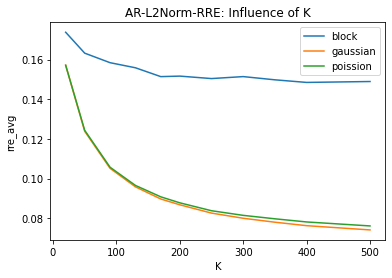

In [ ]:
params={'K':[]}
for i in range(int(len(Fr_l2mur)/2)):
    for k,v in Fr_l2mur[2*i].items():
        if k == 'K':
            params[k].append(v)
# params_grid_l2 = {'K':[20,50,90,130,170,200,250,300,350,400,500]}

plt.plot(params['K'],resultp['AR']['block']['rre_avg'])
plt.plot(params['K'],resultp['AR']['gaussian']['rre_avg'])
plt.plot(params['K'],resultp['AR']['poission']['rre_avg'])
xlab = 'K'
plt.xlabel(xlab)
ylab = 'rre_avg'
plt.ylabel(ylab)
tit = 'AR-L2Norm-RRE: Influence of K'
plt.title(tit)
plt.legend(['block','gaussian','poission'])

### L1-RNMF

In [ ]:
# for l1robust :: 'K': 30, 'lam': 0.3,'tol':1e-6
params_grid_l1r = {'K':[30,40,50,55,60,65,70,75,80,85,90,95,100,105,110,120],
                'lam':[0.3],
                'tol':[1e-6],
               'steps':[5000]}
Fr_l1robust = grid_search("l1robust", NOISE_TYPES, DATASETS, 2, params_grid_l1r)

{'K': 30, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}
step is: 1885
step is: 1524
ORL
block
step is: 1712
step is: 1910
ORL
gaussian
step is: 1612
step is: 1608
ORL
poission
step is: 864
step is: 999
EYB
block
step is: 852
step is: 915
EYB
gaussian
step is: 887
step is: 917
EYB
poission
step is: 742
step is: 709
AR
block
step is: 744
step is: 715
AR
gaussian
step is: 737
step is: 712
AR
poission
{'K': 40, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}
step is: 1375
step is: 1572
ORL
block
step is: 1579
step is: 1606
ORL
gaussian
step is: 1507
step is: 1671
ORL
poission
step is: 817
step is: 727
EYB
block
step is: 750
step is: 725
EYB
gaussian
step is: 775
step is: 755
EYB
poission
step is: 716
step is: 736
AR
block
step is: 709
step is: 767
AR
gaussian
step is: 702
step is: 757
AR
poission
{'K': 50, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}
step is: 1467
step is: 1430
ORL
block
step is: 1647
step is: 1538
ORL
gaussian
step is: 1575
step is: 1446
ORL
poission
step is: 833
step is: 855
EYB
block
s

In [ ]:
show_best_result(Fr_l1robust)

ORL_block_l1robust_rre_avg [0.20239019753824516, {'K': 55, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 3]
ORL_gaussian_l1robust_rre_avg [0.12504091343998897, {'K': 50, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 2]
ORL_poission_l1robust_rre_avg [0.12557522366273946, {'K': 50, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 2]
EYB_block_l1robust_rre_avg [0.22255483203559462, {'K': 60, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 4]
EYB_gaussian_l1robust_rre_avg [0.1688002601807858, {'K': 60, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 4]
EYB_poission_l1robust_rre_avg [0.16778833763708795, {'K': 60, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 4]
AR_block_l1robust_rre_avg [0.13809817882599262, {'K': 105, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 13]
AR_gaussian_l1robust_rre_avg [0.11731227835260141, {'K': 100, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 12]
AR_poission_l1robust_rre_avg [0.11647257668828985, {'K': 105, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000}, 13]


In [ ]:
# l1r-choose K
resultp = {'ORL':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}},
           'EYB':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}},
           'AR':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}}}


for i in range(int(len(Fr_l1robust)/2)):
    for dataset,v in Fr_l1robust[2*i+1].items():
        for noise, v1 in v.items(): 
            for nmf,v2 in v1.items():
                for rr,vs in v2["result"].items():
                    resultp[dataset][noise][rr].append(vs)

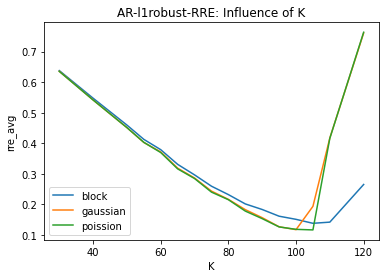

In [ ]:
params={'K':[]}
for i in range(int(len(Fr_l1robust)/2)):
    for k,v in Fr_l1robust[2*i].items():
        if k == 'K':
            params[k].append(v)
# {'K': [10, 20, 30, 50, 70, 100, 150, 200, 250, 300]}

plt.plot(params['K'],resultp['AR']['block']['rre_avg'])
plt.plot(params['K'],resultp['AR']['gaussian']['rre_avg'])
plt.plot(params['K'],resultp['AR']['poission']['rre_avg'])
xlab = 'K'
plt.xlabel(xlab)
ylab = 'rre_avg'
plt.ylabel(ylab)
tit = 'AR-l1robust-RRE: Influence of K'
plt.title(tit)
plt.legend(['block','gaussian','poission'])

### Hypersurface Cost

In [ ]:

params_grid_hyper = {'K':[30,70,110,120,130,150,170,190,210,230,250,270,300],
                 'r': [0.5],'c':[1e-4],'steps': [5000],'t':[1e-4]}
Fr_hyper = grid_search("hypersurface", NOISE_TYPES, DATASETS, 1, params_grid_hyper)

{'K': 30, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}
step is: 958
step is: 958
ORL
block
step is: 4999
ORL
gaussian
step is: 4999
ORL
poission
step is: 1643
step is: 1643
EYB
block
step is: 833
step is: 833
EYB
gaussian
step is: 1156
step is: 1156
EYB
poission
step is: 711
step is: 711
AR
block
step is: 594
step is: 594
AR
gaussian
step is: 609
step is: 609
AR
poission
{'K': 70, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}
step is: 928
step is: 928
ORL
block
step is: 665
step is: 665
ORL
gaussian
step is: 693
step is: 693
ORL
poission
step is: 1490
step is: 1490
EYB
block
step is: 1131
step is: 1131
EYB
gaussian
step is: 1236
step is: 1236
EYB
poission
step is: 824
step is: 824
AR
block
step is: 631
step is: 631
AR
gaussian
step is: 627
step is: 627
AR
poission
{'K': 110, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}
step is: 863
step is: 863
ORL
block
step is: 764
step is: 764
ORL
gaussian
step is: 756
step is: 756
ORL
poission
step is: 1469
step is: 1469
EYB
block


In [ ]:
show_best_result(Fr_hyper)

ORL_block_hypersurface_rre_avg [0.22720880013312955, {'K': 270, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 11]
ORL_gaussian_hypersurface_rre_avg [0.09357469825187713, {'K': 300, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 12]
ORL_poission_hypersurface_rre_avg [0.09587987874816604, {'K': 300, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 12]
EYB_block_hypersurface_rre_avg [0.3068079774828485, {'K': 30, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 0]
EYB_gaussian_hypersurface_rre_avg [0.14242105368311694, {'K': 250, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 10]
EYB_poission_hypersurface_rre_avg [0.13976696524693577, {'K': 250, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 10]
AR_block_hypersurface_rre_avg [0.14940183974796864, {'K': 300, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 12]
AR_gaussian_hypersurface_rre_avg [0.09333823958787771, {'K': 300, 'r': 0.5, 'c': 0.0001, 'steps': 5000, 't': 0.0001}, 12]
AR_poission_hypersurface_rre_a

In [ ]:
# hyper-choose K
resultp = {'ORL':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}},
           'EYB':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}},
           'AR':{'block':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'gaussian':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'poission':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}}}


for i in range(int(len(Fr_hyper)/2)):
    for dataset,v in Fr_hyper[2*i+1].items():
        for noise, v1 in v.items(): 
            for nmf,v2 in v1.items():
                for rr,vs in v2["result"].items():
                    resultp[dataset][noise][rr].append(vs)

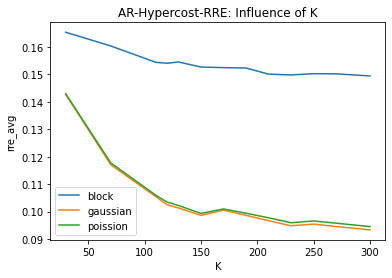

In [ ]:
params={'K':[]}
for i in range(int(len(Fr_hyper)/2)):
    for k,v in Fr_hyper[2*i].items():
        if k == 'K':
            params[k].append(v)
# {'K':AR-Hypercost-RRE: Influence of K [10,20,30,50,70,100,150,200,250,300]}

plt.plot(params['K'],resultp['AR']['block']['rre_avg'])
plt.plot(params['K'],resultp['AR']['gaussian']['rre_avg'])
plt.plot(params['K'],resultp['AR']['poission']['rre_avg'])
xlab = 'K'
plt.xlabel(xlab)
ylab = 'rre_avg'
plt.ylabel(ylab)
tit = 'AR-Hypercost-RRE: Influence of K'
plt.title(tit)
plt.legend(['block','gaussian','poission'])

## Robustness to Noise

In [ ]:
params_dict_ORL = {'l2':{'K':300},
               'l1robust':{'K': 50, 'lam': 0.3,'tol':1e-6,'steps': 5000},
               'hypersurface':{'K': 250, 'r': 0.5,'c':1e-4,'steps': 5000,'t':1e-7},
               }
params_dict_EYB = {'l2':{'K':300},
                   'l1robust':{'K': 60, 'lam': 0.3,'tol':1e-6,'steps': 5000},
                   'hypersurface':{'K': 250, 'r': 0.5,'c':1e-4,'steps': 5000,'t':1e-7},
                   }
params_dict_AR = {'l2':{'K':300},
               'l1robust':{'K': 100, 'lam': 0.3,'tol':1e-6,'steps': 5000},
               'hypersurface':{'K': 250, 'r': 0.5,'c':1e-4,'steps': 5000,'t':1e-7},
               }


### Effect of the Noise Control Parameter

#### Block Size

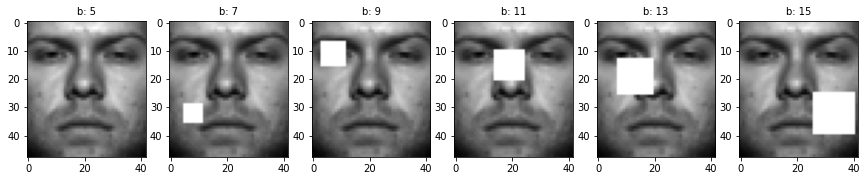

In [ ]:
blocksize = [5,7,9,11,13,15]

i=1
plt.figure(1,(20,20))
for bs in blocksize:
    noise,noisyx = noise_block(EYB_X,IMAGE_SHAPE["EYB"],b=bs)
    # DATASETS["EYB"]["X"][:,idx][:,ind].reshape(IMAGE_SHAPE["EYB"][1],IMAGE_SHAPE["EYB"][0])
    plt.subplot(1,8,i)
    i += 1
    plt.imshow(noisyx[:,13].reshape(IMAGE_SHAPE["EYB"][1],IMAGE_SHAPE["EYB"][0]), cmap=plt.cm.gray)
    title = 'b: '+str(bs)
    plt.title(title,fontsize = 10)

In [ ]:
NMF_TYPES = ["l2","l1robust","hypersurface"]
NOISE_TYPES = {"block":noise_block}
DATASETS_AR = {"AR":{"X":AR_X,"Y":AR_Y}}
# DATASETS = {"ORL":{"X":ORL_X,"Y":ORL_Y},"EYB":{"X":EYB_X,"Y":EYB_Y},"AR":{"X":AR_X,"Y":AR_Y}}
               
blocksize = [5,7,9,11,13,15]
F_results_blocktesting = {}

for b in blocksize:
    F_results_blocktesting[b] = experiments(NMF_TYPES,NOISE_TYPES,DATASETS_AR,1,params_dict_AR,b)

blocksize = [5,7,9,11,13,15]

for b in blocksize:
    print(b)
    print('AR-block-l2:')
    print(F_results_blocktesting[b]['AR']['block']['l2']['result'])
    print('AR-block-l1robust:')
    print(F_results_blocktesting[b]['AR']['block']['l1robust']['result'])
    print('AR-block-hypersurface:')
    print(F_results_blocktesting[b]['AR']['block']['hypersurface']['result'])

step is: 488
AR
step is: 799
AR
step is: 4999
AR
step is: 489
AR
step is: 824
AR
step is: 4999
AR
step is: 499
AR
step is: 815
AR
step is: 4999
AR
step is: 500
AR
step is: 773
AR
step is: 4999
AR
step is: 514
AR
step is: 795
AR
step is: 4999
AR
step is: 522
AR
step is: 787
AR
step is: 4999
AR
5
AR-block-l2:
{'rre_avg': 0.10472952446942127, 'rre_std': 0.0, 'acc_avg': 0.20256410256410257, 'acc_std': 0.0, 'nmi_avg': 0.40484473407029753, 'nmi_std': 0.0}
AR-block-l1robust:
{'rre_avg': 0.12089888852913354, 'rre_std': 0.0, 'acc_avg': 0.15683760683760684, 'acc_std': 0.0, 'nmi_avg': 0.4007736789326269, 'nmi_std': 0.0}
AR-block-hypersurface:
{'rre_avg': 0.10056320540597341, 'rre_std': 0.0, 'acc_avg': 0.21495726495726497, 'acc_std': 0.0, 'nmi_avg': 0.4254946132273376, 'nmi_std': 0.0}
7
AR-block-l2:
{'rre_avg': 0.13474427259126467, 'rre_std': 0.0, 'acc_avg': 0.1876068376068376, 'acc_std': 0.0, 'nmi_avg': 0.41000954345707863, 'nmi_std': 0.0}
AR-block-l1robust:
{'rre_avg': 0.1461201182893796, 'rre_s

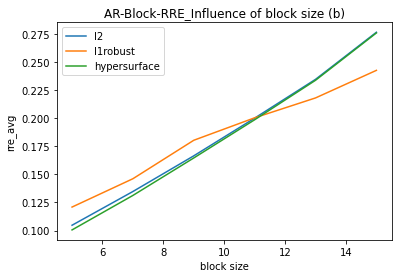

In [ ]:

result_block = {'AR':{'l2':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'l1robust':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'hypersurface':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}}}
for b, v in F_results_blocktesting.items():
    for dataset,v0 in v.items():
        for noise, v1 in v0.items(): 
            for nmf,v2 in v1.items():
                for rr,vs in v2["result"].items():
                    result_block[dataset][nmf][rr].append(vs)

params={'b':[5,7,9,11,13,15]}


plt.plot(params['b'],result_block['AR']['l2']['rre_avg'])
plt.plot(params['b'],result_block['AR']['l1robust']['rre_avg'])
plt.plot(params['b'],result_block['AR']['hypersurface']['rre_avg'])
xlab = 'block size'
plt.xlabel(xlab)
ylab = 'rre_avg'
plt.ylabel(ylab)
tit = 'AR-Block-RRE_Influence of block size (b)'
plt.title(tit)
plt.legend(['l2','l1robust','hypersurface'])

#### Poisson Noise

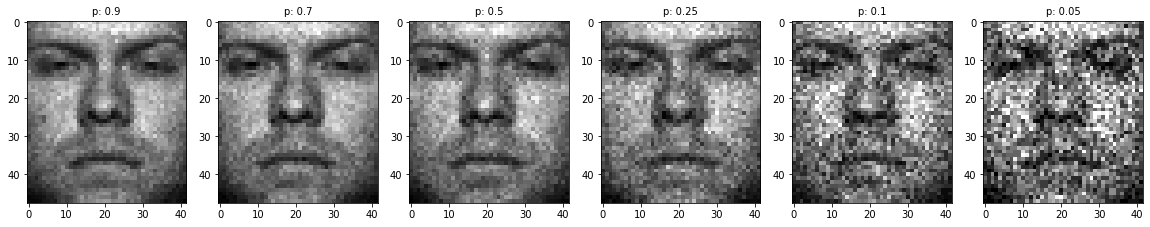

In [ ]:
## Poisson - PeakValue

peakvalue = [0.9,0.7,0.5,0.25,0.1,0.05]

# noise, noisy_x = noise_poisson(X,pe=p)
i=1
plt.figure(1,(20,20))
for p in peakvalue:
    # print(p)
    noise,noisyx = noise_poisson(EYB_X,pe=p)
    # DATASETS["EYB"]["X"][:,idx][:,ind].reshape(IMAGE_SHAPE["EYB"][1],IMAGE_SHAPE["EYB"][0])
    plt.subplot(1,6,i)
    i += 1
    plt.imshow(noisyx[:,13].reshape(IMAGE_SHAPE["EYB"][1],IMAGE_SHAPE["EYB"][0]), cmap=plt.cm.gray)
    title = 'p: '+str(p)
    plt.title(title,fontsize = 10)

In [ ]:
NMF_TYPES = ["l2","l1robust","hypersurface"]
NOISE_TYPES = {"poission":noise_poisson}
DATASETS_AR = {"AR":{"X":AR_X,"Y":AR_Y}}
# DATASETS = {"ORL":{"X":ORL_X,"Y":ORL_Y},"EYB":{"X":EYB_X,"Y":EYB_Y},"AR":{"X":AR_X,"Y":AR_Y}}
peakvalue = [0.9,0.7,0.5,0.25,0.1,0.05]


F_results_poissontesting = {}

for pea in peakvalue:
    F_results_poissontesting[pea] = experiments(NMF_TYPES,DATASETS_AR,1,params_dict_AR,pea)

for pea in peakvalue:
    print(pea)
    print('AR-poisson-l2:')
    print(F_results_poissontesting[pea]['AR']['poission']['l2']['result'])
    print('AR-poisson-l1robust:')
    print(F_results_poissontesting[pea]['AR']['poission']['l1robust']['result'])
    print('AR-poisson-hypersurface:')
    print(F_results_poissontesting[pea]['AR']['poission']['hypersurface']['result'])

step is: 475
AR
step is: 1026
AR
step is: 4999
AR
step is: 476
AR
step is: 1030
AR
step is: 4999
AR
step is: 481
AR
step is: 1080
AR
step is: 4999
AR
step is: 483
AR
step is: 1225
AR
step is: 4999
AR
step is: 508
AR
step is: 1688
AR
step is: 4999
AR
step is: 548
AR
step is: 1202
AR
step is: 4999
AR
0.9
AR-poisson-l2:
{'rre_avg': 0.08010358761973702, 'rre_std': 0.0, 'acc_avg': 0.2012820512820513, 'acc_std': 0.0, 'nmi_avg': 0.4182952012427471, 'nmi_std': 0.0}
AR-poisson-l1robust:
{'rre_avg': 0.12368604643205541, 'rre_std': 0.0, 'acc_avg': 0.15, 'acc_std': 0.0, 'nmi_avg': 0.3918846184475017, 'nmi_std': 0.0}
AR-poisson-hypersurface:
{'rre_avg': 0.07209518929758728, 'rre_std': 0.0, 'acc_avg': 0.2858974358974359, 'acc_std': 0.0, 'nmi_avg': 0.4757397163348341, 'nmi_std': 0.0}
0.7
AR-poisson-l2:
{'rre_avg': 0.08178035782751356, 'rre_std': 0.0, 'acc_avg': 0.19914529914529913, 'acc_std': 0.0, 'nmi_avg': 0.4100318746785905, 'nmi_std': 0.0}
AR-poisson-l1robust:
{'rre_avg': 0.1238988207441845, 'rre

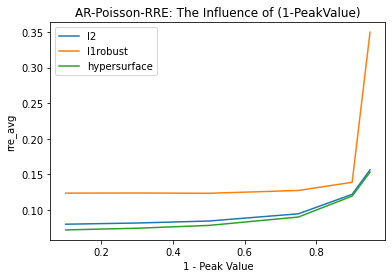

In [ ]:

result_poisson = {'AR':{'l2':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'l1robust':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'hypersurface':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}}}


for b, v in F_results_poissontesting.items():
    for dataset,v0 in v.items():
        for noise, v1 in v0.items(): 
            for nmf,v2 in v1.items():
                for rr,vs in v2["result"].items():
                    result_poisson[dataset][nmf][rr].append(vs)

params={'1-p':[0.1,0.3,0.5,0.75,0.9,0.95]
}


plt.plot(params['1-p'],result_poisson['AR']['l2']['rre_avg'])
plt.plot(params['1-p'],result_poisson['AR']['l1robust']['rre_avg'])
plt.plot(params['1-p'],result_poisson['AR']['hypersurface']['rre_avg'])
xlab = '1 - Peak Value'
plt.xlabel(xlab)
ylab = 'rre_avg'
plt.ylabel(ylab)
tit = 'AR-Poisson-RRE: The Influence of (1-PeakValue)'
plt.title(tit)
plt.legend(['l2','l1robust','hypersurface'])

#### Gaussian Noise

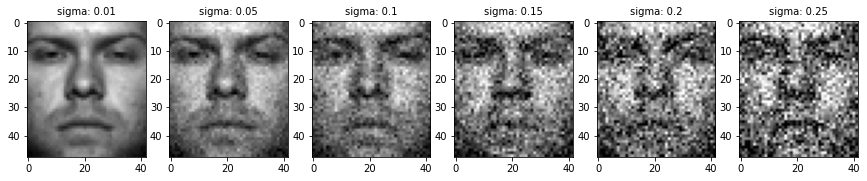

In [ ]:
## Gaussian - sigma



sigmavalue = [0.01,0.05,0.1,0.15,0.2,0.25]

i=1
plt.figure(1,(20,20))
for sg in sigmavalue:
    noise,noisyx = noise_gaussian(EYB_X,sigma=sg)
    plt.subplot(1,8,i)
    i += 1
    plt.imshow(noisyx[:,13].reshape(IMAGE_SHAPE["EYB"][1],IMAGE_SHAPE["EYB"][0]), cmap=plt.cm.gray)
    title = 'sigma: '+str(sg)
    plt.title(title,fontsize = 10)

In [ ]:
NMF_TYPES = ["l2","l1robust","hypersurface"]
NOISE_TYPES = {"gaussian":noise_gaussian}
DATASETS_AR = {"AR":{"X":AR_X,"Y":AR_Y}}
sigmavalue = [0.01,0.05,0.1,0.15,0.2,0.25]
F_results_gaussiantesting = {}

for sg in sigmavalue:
    F_results_gaussiantesting[sg] = experiments(NMF_TYPES,NOISE_TYPES,DATASETS_AR,1,params_dict_AR,sg)

for sg in sigmavalue:
    print(sg)
    print('AR-gaussian-l2:')
    print(F_results_gaussiantesting[sg]['AR']['gaussian']['l2']['result'])
    print('AR-gaussian-l1robust:')
    print(F_results_gaussiantesting[sg]['AR']['gaussian']['l1robust']['result'])
    print('AR-gaussian-hypersurface:')
    print(F_results_gaussiantesting[sg]['AR']['gaussian']['hypersurface']['result'])

step is: 469
AR
gaussian
step is: 874
AR
gaussian
step is: 879
step is: 879
AR
gaussian
step is: 482
AR
gaussian
step is: 983
AR
gaussian
step is: 878
step is: 878
AR
gaussian
step is: 491
AR
gaussian
step is: 1219
AR
gaussian
step is: 963
step is: 963
AR
gaussian
step is: 514
AR
gaussian
step is: 1550
AR
gaussian
step is: 1075
step is: 1075
AR
gaussian
step is: 551
AR
gaussian
step is: 1212
AR
gaussian
step is: 1151
step is: 1151
AR
gaussian
step is: 577
AR
gaussian
step is: 1297
AR
gaussian
step is: 1293
step is: 1293
AR
gaussian
0.01
AR-gaussian-l2:
{'rre_avg': 0.07496510788685545, 'rre_std': 0.0, 'acc_avg': 0.2111111111111111, 'acc_std': 0.0, 'nmi_avg': 0.4137838498303356, 'nmi_std': 0.0}
AR-gaussian-l1robust:
{'rre_avg': 0.11892587345811244, 'rre_std': 0.0, 'acc_avg': 0.18846153846153846, 'acc_std': 0.0, 'nmi_avg': 0.4172998777217198, 'nmi_std': 0.0}
AR-gaussian-hypersurface:
{'rre_avg': 0.08702216847207257, 'rre_std': 0.0, 'acc_avg': 0.24914529914529915, 'acc_std': 0.0, 'nmi_avg'

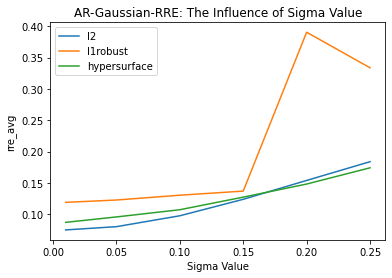

In [ ]:
result_gaussian = {'AR':{'l2':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'l1robust':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]},
           'hypersurface':{'rre_avg':[],'rre_std':[],'acc_avg':[],'acc_std':[],'nmi_avg':[],'nmi_std':[]}}}


for b, v in F_results_gaussiantesting.items():
    for dataset,v0 in v.items():
        for noise, v1 in v0.items(): 
            for nmf,v2 in v1.items():
                for rr,vs in v2["result"].items():
                    result_gaussian[dataset][nmf][rr].append(vs)

params={'sigma':[0.01,0.05,0.1,0.15,0.2,0.25]}

plt.plot(params['sigma'],result_gaussian['AR']['l2']['rre_avg'])
plt.plot(params['sigma'],result_gaussian['AR']['l1robust']['rre_avg'])
plt.plot(params['sigma'],result_gaussian['AR']['hypersurface']['rre_avg'])
xlab = 'Sigma Value'
plt.xlabel(xlab)
ylab = 'rre_avg'
plt.ylabel(ylab)
tit = 'AR-Gaussian-RRE: The Influence of Sigma Value'
plt.title(tit)
plt.legend(['l2','l1robust','hypersurface'])

## NMF Performance of each Noise Type on Different Dataset

### ORL

In [ ]:
# l2 {'K': 170} -> larger K associated with much higher performance -- but when k>150/170, the performance improvment is gradually slowed
# l1robust {'K': 70, 'lam': 0.3, 'tol': 1e-06, 'steps': 5000} 0.17 0.18 0.22 -for EYB:{'K': 105, 'lam': 0.07,'tol':1e-6,'steps': 5000}
# hyper 0.01 0.005 0.0001 =1e-6
NMF_TYPES = ["l2","l1robust","hypersurface"]
NOISE_TYPES = {"block":noise_block, "gaussian":noise_gaussian, "poission":noise_poisson}
# DATASETS = {"ORL":{"X":ORL_X,"Y":ORL_Y},"EYB":{"X":EYB_X,"Y":EYB_Y},"AR":{"X":AR_X,"Y":AR_Y}}

DATASETS_ORL = {"ORL":{"X":ORL_X,"Y":ORL_Y}}

params_dict_ORL = {'l2':{'K':300},
               'l1robust':{'K': 50, 'lam': 0.3,'tol':1e-6,'steps': 5000},
               'hypersurface':{'K': 250, 'r': 0.5,'c':1e-4,'steps': 5000,'t':1e-4},
               }

F_results_ORL = experiments(NMF_TYPES,NOISE_TYPES,DATASETS_ORL,5,params_dict_ORL)
# training :: for each dataset(3) - for each noise(3) - for each nmf(3) :: train 5 times == 3x3x3x5
# training order = mnist-block-l2, mnist-block-l1robust, mnist-block-hypersurface, mnist-gaussian-l2, mnist-gaussian-l1robust,...,mnist-poission-hypersurface,EYB-block-l2,..EYB-gaussian-l1robust,..,EYB-possion-hypersurface,AR-block-l2,..AR-gaussian-l1robust,..,AR-possion-hypersurface


step is: 340
step is: 339
step is: 344
step is: 330
step is: 342
ORL
block
step is: 1566
step is: 1388
step is: 1417
step is: 1655
step is: 1436
ORL
block
step is: 792
step is: 792
step is: 909
step is: 909
step is: 842
step is: 842
step is: 839
step is: 839
step is: 771
step is: 771
ORL
block
step is: 364
step is: 361
step is: 367
step is: 367
step is: 360
ORL
gaussian
step is: 1743
step is: 1685
step is: 4089
step is: 1584
step is: 1554
ORL
gaussian
step is: 750
step is: 750
step is: 767
step is: 767
step is: 774
step is: 774
step is: 774
step is: 774
step is: 743
step is: 743
ORL
gaussian
step is: 357
step is: 357
step is: 367
step is: 364
step is: 364
ORL
poission
step is: 1960
step is: 1658
step is: 1817
step is: 1610
step is: 1674
ORL
poission
step is: 746
step is: 746
step is: 757
step is: 757
step is: 772
step is: 772
step is: 779
step is: 779
step is: 742
step is: 742
ORL
poission


In [ ]:
# NMF_TYPES = ["l2","l1robust","hypersurface"]
# NOISE_TYPES = {"block":noise_block, "gaussian":noise_gaussian, "poission":noise_poisson}
# F_results = {dataset:{noise:{nmf:{'result':result},'P':([]),'Q':([]),'R':([])}}}

print('ORL-block-l2:')
print(F_results_ORL['ORL']['block']['l2']['result'])
print('ORL-block-l1robust:')
print(F_results_ORL['ORL']['block']['l1robust']['result'])
print('ORL-block-hypersurface:')
print(F_results_ORL['ORL']['block']['hypersurface']['result'])

print('ORL-gaussian-l2:')
print(F_results_ORL['ORL']['gaussian']['l2']['result'])
print('ORL-gaussian-l1robust:')
print(F_results_ORL['ORL']['gaussian']['l1robust']['result'])
print('ORL-gaussian-hypersurface:')
print(F_results_ORL['ORL']['gaussian']['hypersurface']['result'])

print('ORL-poission-l2:')
print(F_results_ORL['ORL']['poission']['l2']['result'])
print('ORL-poission-l1robust:')
print(F_results_ORL['ORL']['poission']['l1robust']['result'])
print('ORL-poission-hypersurface:')
print(F_results_ORL['ORL']['poission']['hypersurface']['result'])

ORL-block-l2:
{'rre_avg': 0.2361359617573327, 'rre_std': 0.001239703343929486, 'acc_avg': 0.44333333333333336, 'acc_std': 0.011194134266449936, 'nmi_avg': 0.6044390290363866, 'nmi_std': 0.015601640971882437}
ORL-block-l1robust:
{'rre_avg': 0.20212372168816234, 'rre_std': 0.0008416215907222105, 'acc_avg': 0.6766666666666667, 'acc_std': 0.02068278940998477, 'nmi_avg': 0.8024054162267328, 'nmi_std': 0.008977263578268271}
ORL-block-hypersurface:
{'rre_avg': 0.23224512782365342, 'rre_std': 0.0013757720606784533, 'acc_avg': 0.40444444444444444, 'acc_std': 0.017356110390903675, 'nmi_avg': 0.5562189761445494, 'nmi_std': 0.011560796108544309}
ORL-gaussian-l2:
{'rre_avg': 0.09123928560768878, 'rre_std': 0.00016939199965774029, 'acc_avg': 0.635, 'acc_std': 0.029112383347942014, 'nmi_avg': 0.777061112850264, 'nmi_std': 0.014772309899318608}
ORL-gaussian-l1robust:
{'rre_avg': 0.14805895079497547, 'rre_std': 0.04850082836378625, 'acc_avg': 0.7416666666666667, 'acc_std': 0.009781564923143898, 'nmi_av

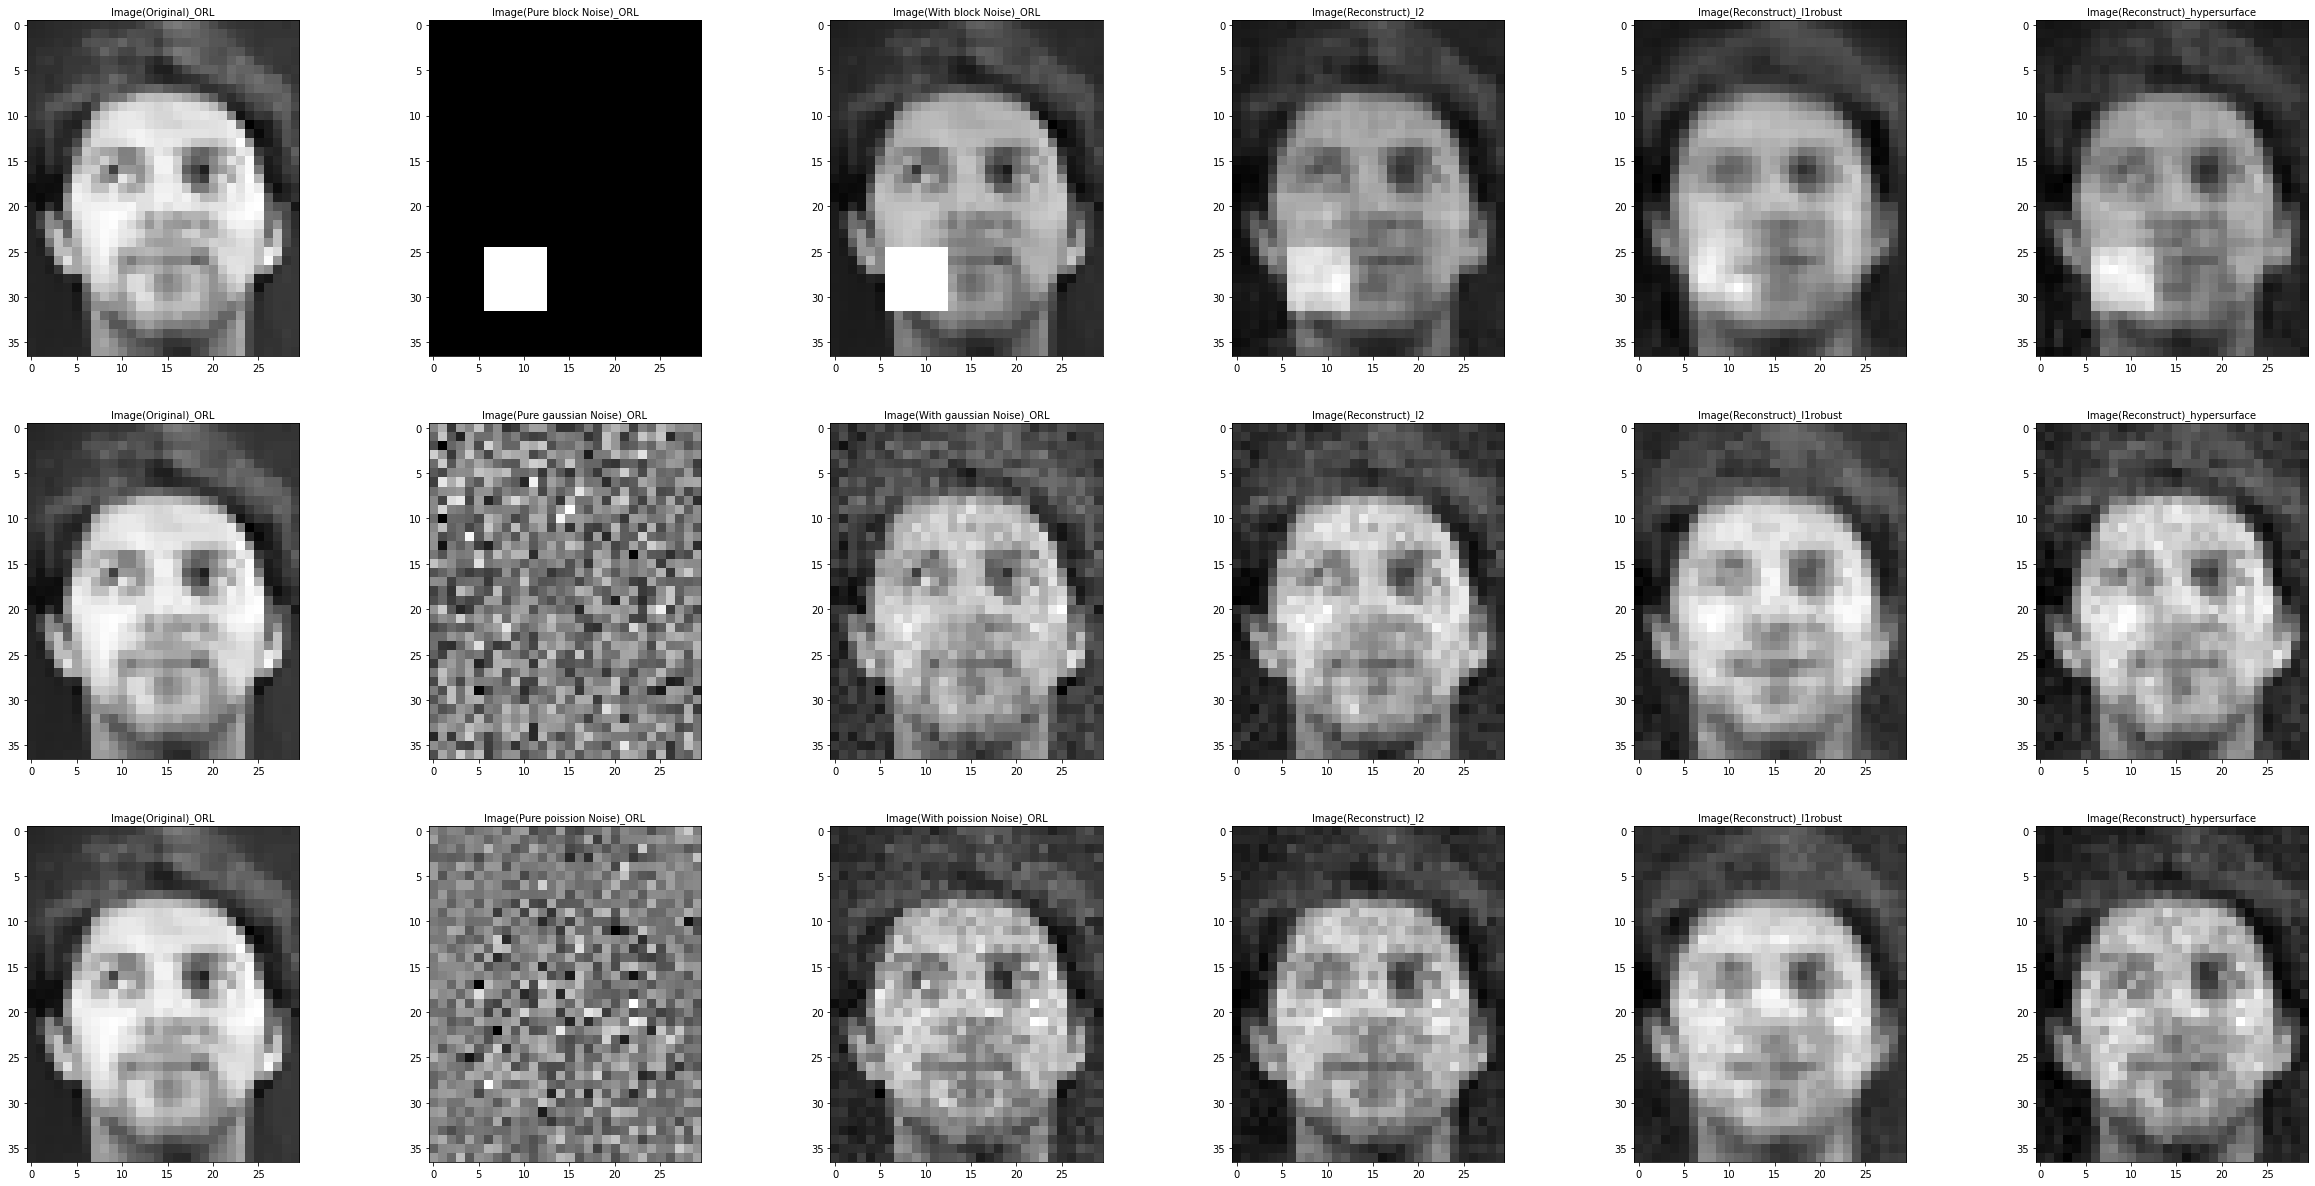

In [ ]:
plot_images(F_results_ORL,DATASETS_ORL,ind=177)

### EYB

In [ ]:
DATASETS_EYB = {"EYB":{"X":EYB_X,"Y":EYB_Y}}
# {'K': 60, 'lam': 0.03, 'tol': 1e-06, 'steps': 5000}
params_dict_EYB = {'l2':{'K':300},
               'l1robust':{'K': 60, 'lam': 0.3,'tol':1e-6,'steps': 5000},
               'hypersurface':{'K': 250, 'r': 0.5,'c':1e-4,'steps': 5000,'t':1e-4},
               }

F_results_EYB = experiments(NMF_TYPES,NOISE_TYPES,DATASETS_EYB,5,params_dict_EYB)

step is: 750
step is: 731
step is: 760
step is: 738
step is: 788
EYB
block
step is: 1120
step is: 1175
step is: 1125
step is: 1138
step is: 1072
EYB
block
step is: 1635
step is: 1635
step is: 1648
step is: 1648
step is: 1583
step is: 1583
step is: 1584
step is: 1584
step is: 1617
step is: 1617
EYB
block
step is: 614
step is: 627
step is: 616
step is: 628
step is: 639
EYB
gaussian
step is: 1451
step is: 1571
step is: 1143
step is: 1230
step is: 1303
EYB
gaussian
step is: 1168
step is: 1168
step is: 1257
step is: 1257
step is: 1236
step is: 1236
step is: 1252
step is: 1252
step is: 1225
step is: 1225
EYB
gaussian
step is: 623
step is: 636
step is: 629
step is: 633
step is: 640
EYB
poission
step is: 1412
step is: 1457
step is: 1265
step is: 1417
step is: 1423
EYB
poission
step is: 1187
step is: 1187
step is: 1291
step is: 1291
step is: 1244
step is: 1244
step is: 1288
step is: 1288
step is: 1256
step is: 1256
EYB
poission


In [ ]:
# NMF_TYPES = ["l2","l1robust","hypersurface"]
# NOISE_TYPES = {"block":noise_block, "gaussian":noise_gaussian, "poission":noise_poisson}
# F_results = {dataset:{noise:{nmf:{'result':result},'P':([]),'Q':([]),'R':([])}}}

print('EYB-block-l2:')
print(F_results_EYB['EYB']['block']['l2']['result'])
print('EYB-block-l1robust:')
print(F_results_EYB['EYB']['block']['l1robust']['result'])
print('EYB-block-hypersurface:')
print(F_results_EYB['EYB']['block']['hypersurface']['result'])

print('EYB-gaussian-l2:')
print(F_results_EYB['EYB']['gaussian']['l2']['result'])
print('EYB-gaussian-l1robust:')
print(F_results_EYB['EYB']['gaussian']['l1robust']['result'])
print('EYB-gaussian-hypersurface:')
print(F_results_EYB['EYB']['gaussian']['hypersurface']['result'])

print('EYB-poission-l2:')
print(F_results_EYB['EYB']['poission']['l2']['result'])
print('EYB-poission-l1robust:')
print(F_results_EYB['EYB']['poission']['l1robust']['result'])
print('EYB-poission-hypersurface:')
print(F_results_EYB['EYB']['poission']['hypersurface']['result'])

EYB-block-l2:
{'rre_avg': 0.3150349593121959, 'rre_std': 0.0009139274451224591, 'acc_avg': 0.2680478821362799, 'acc_std': 0.010143134165913323, 'nmi_avg': 0.3331020023344848, 'nmi_std': 0.015135510364093828}
EYB-block-l1robust:
{'rre_avg': 0.22281060991491292, 'rre_std': 0.0031381782975344937, 'acc_avg': 0.2214548802946593, 'acc_std': 0.008069577274477584, 'nmi_avg': 0.2855475636669329, 'nmi_std': 0.007206606715989025}
EYB-block-hypersurface:
{'rre_avg': 0.31402838150763357, 'rre_std': 0.0010920736964839326, 'acc_avg': 0.20368324125230203, 'acc_std': 0.008834981816803675, 'nmi_avg': 0.25144265124309445, 'nmi_std': 0.016531484062701253}
EYB-gaussian-l2:
{'rre_avg': 0.10156750066171898, 'rre_std': 0.00011857414596822253, 'acc_avg': 0.3432780847145488, 'acc_std': 0.027004401078174322, 'nmi_avg': 0.40025599262491773, 'nmi_std': 0.019410458417098434}
EYB-gaussian-l1robust:
{'rre_avg': 0.18260451308347295, 'rre_std': 0.02773040002433244, 'acc_avg': 0.2429097605893186, 'acc_std': 0.0103835398

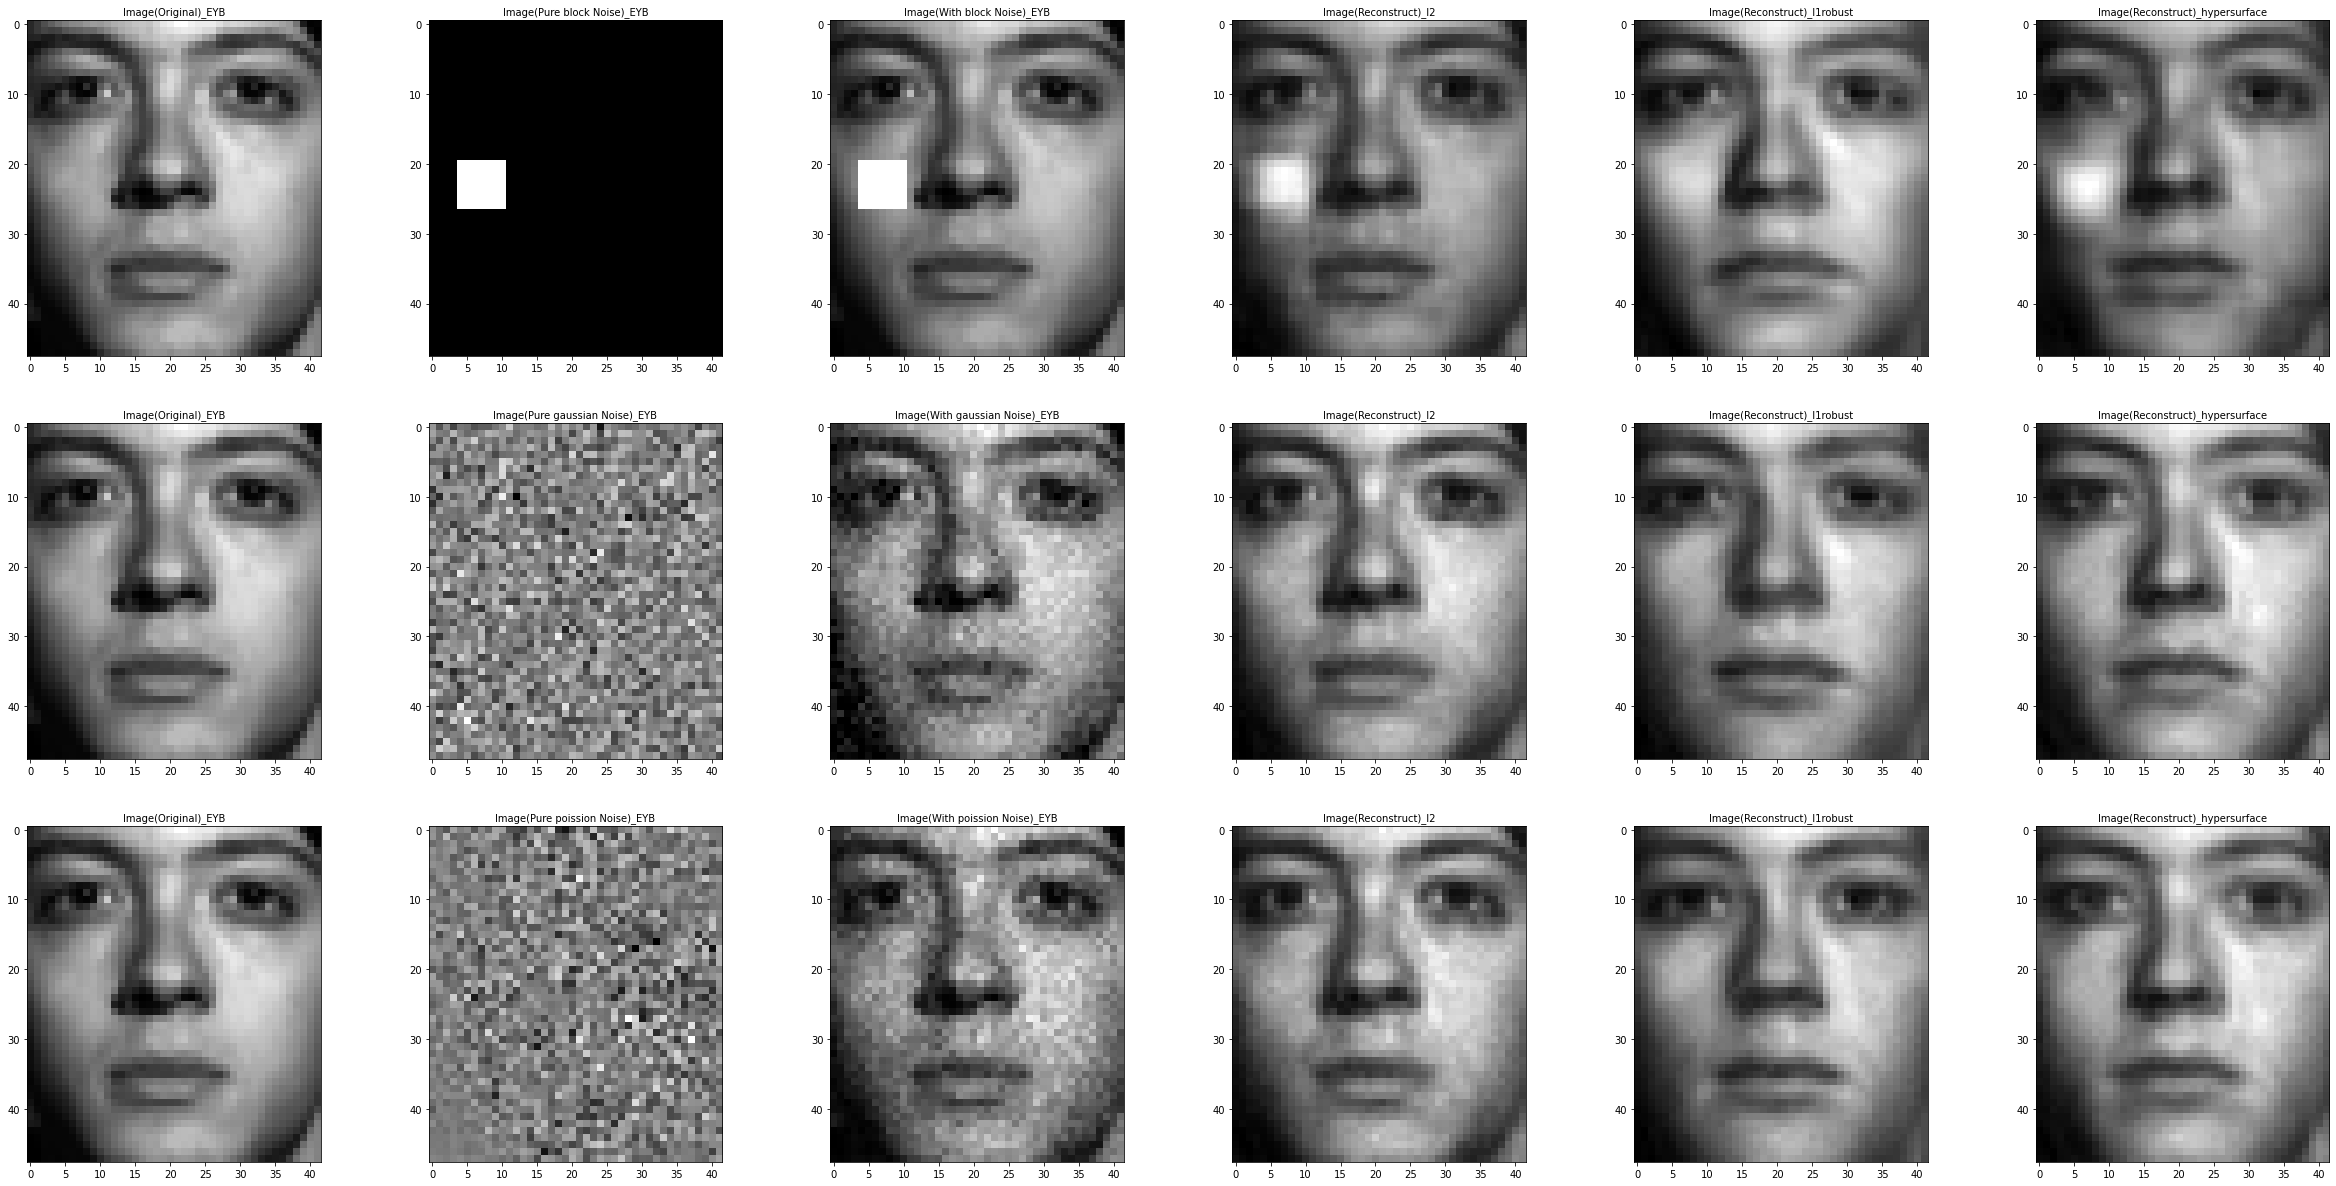

In [ ]:
plot_images(F_results_EYB,DATASETS_EYB,ind=777)

### AR

In [ ]:
DATASETS_AR = {"AR":{"X":AR_X,"Y":AR_Y}}

# 'K':[30,40,50,55,60,65,70,75,80,85,90,95,100,105,110,120]

params_dict_AR = {'l2':{'K':300},
               'l1robust':{'K': 100, 'lam': 0.3,'tol':1e-6,'steps': 5000},
               'hypersurface':{'K': 250, 'r': 0.5,'c':1e-4,'steps': 5000,'t':1e-4},
               }

F_results_AR = experiments(NMF_TYPES,NOISE_TYPES,DATASETS_AR,5,params_dict_AR)

step is: 493
step is: 478
step is: 496
step is: 499
step is: 485
AR
block
step is: 811
step is: 795
step is: 807
step is: 810
step is: 807
AR
block
step is: 944
step is: 944
step is: 933
step is: 933
step is: 937
step is: 937
step is: 927
step is: 927
step is: 930
step is: 930
AR
block
step is: 476
step is: 471
step is: 479
step is: 479
step is: 473
AR
gaussian
step is: 938
step is: 953
step is: 889
step is: 883
step is: 881
AR
gaussian
step is: 870
step is: 870
step is: 882
step is: 882
step is: 864
step is: 864
step is: 858
step is: 858
step is: 885
step is: 885
AR
gaussian
step is: 477
step is: 467
step is: 475
step is: 481
step is: 470
AR
poission
step is: 958
step is: 1074
step is: 948
step is: 904
step is: 949
AR
poission
step is: 847
step is: 847
step is: 886
step is: 886
step is: 850
step is: 850
step is: 854
step is: 854
step is: 888
step is: 888
AR
poission


In [ ]:
# NMF_TYPES = ["l2","l1robust","hypersurface"]
# NOISE_TYPES = {"block":noise_block, "gaussian":noise_gaussian, "poission":noise_poisson}
# F_results = {dataset:{noise:{nmf:{'result':result},'P':([]),'Q':([]),'R':([])}}}

print('AR-block-l2:')
print(F_results_AR['AR']['block']['l2']['result'])
print('AR-block-l1robust:')
print(F_results_AR['AR']['block']['l1robust']['result'])
print('AR-block-hypersurface:')
print(F_results_AR['AR']['block']['hypersurface']['result'])

print('AR-gaussian-l2:')
print(F_results_AR['AR']['gaussian']['l2']['result'])
print('AR-gaussian-l1robust:')
print(F_results_AR['AR']['gaussian']['l1robust']['result'])
print('AR-gaussian-hypersurface:')
print(F_results_AR['AR']['gaussian']['hypersurface']['result'])

print('AR-poission-l2:')
print(F_results_AR['AR']['poission']['l2']['result'])
print('AR-poission-l1robust:')
print(F_results_AR['AR']['poission']['l1robust']['result'])
print('AR-poission-hypersurface:')
print(F_results_AR['AR']['poission']['hypersurface']['result'])

AR-block-l2:
{'rre_avg': 0.14959226074578144, 'rre_std': 0.00031080591425504953, 'acc_avg': 0.1735897435897436, 'acc_std': 0.012943568974297165, 'nmi_avg': 0.38685399345360244, 'nmi_std': 0.008675158096244666}
AR-block-l1robust:
{'rre_avg': 0.15096703480615883, 'rre_std': 0.003452287649809182, 'acc_avg': 0.16991452991452988, 'acc_std': 0.00614909598242904, 'nmi_avg': 0.40059994439040525, 'nmi_std': 0.009647163228172431}
AR-block-hypersurface:
{'rre_avg': 0.14952755990277705, 'rre_std': 0.0002805720354146778, 'acc_avg': 0.1846153846153846, 'acc_std': 0.007206907344900103, 'nmi_avg': 0.3980184722918271, 'nmi_std': 0.01046057950185703}
AR-gaussian-l2:
{'rre_avg': 0.08016038014789424, 'rre_std': 0.00011741743181648844, 'acc_avg': 0.2109401709401709, 'acc_std': 0.007723583143646059, 'nmi_avg': 0.41348531093792734, 'nmi_std': 0.01030123699860336}
AR-gaussian-l1robust:
{'rre_avg': 0.11763643109291907, 'rre_std': 0.004379374395680304, 'acc_avg': 0.1700854700854701, 'acc_std': 0.001852947298177

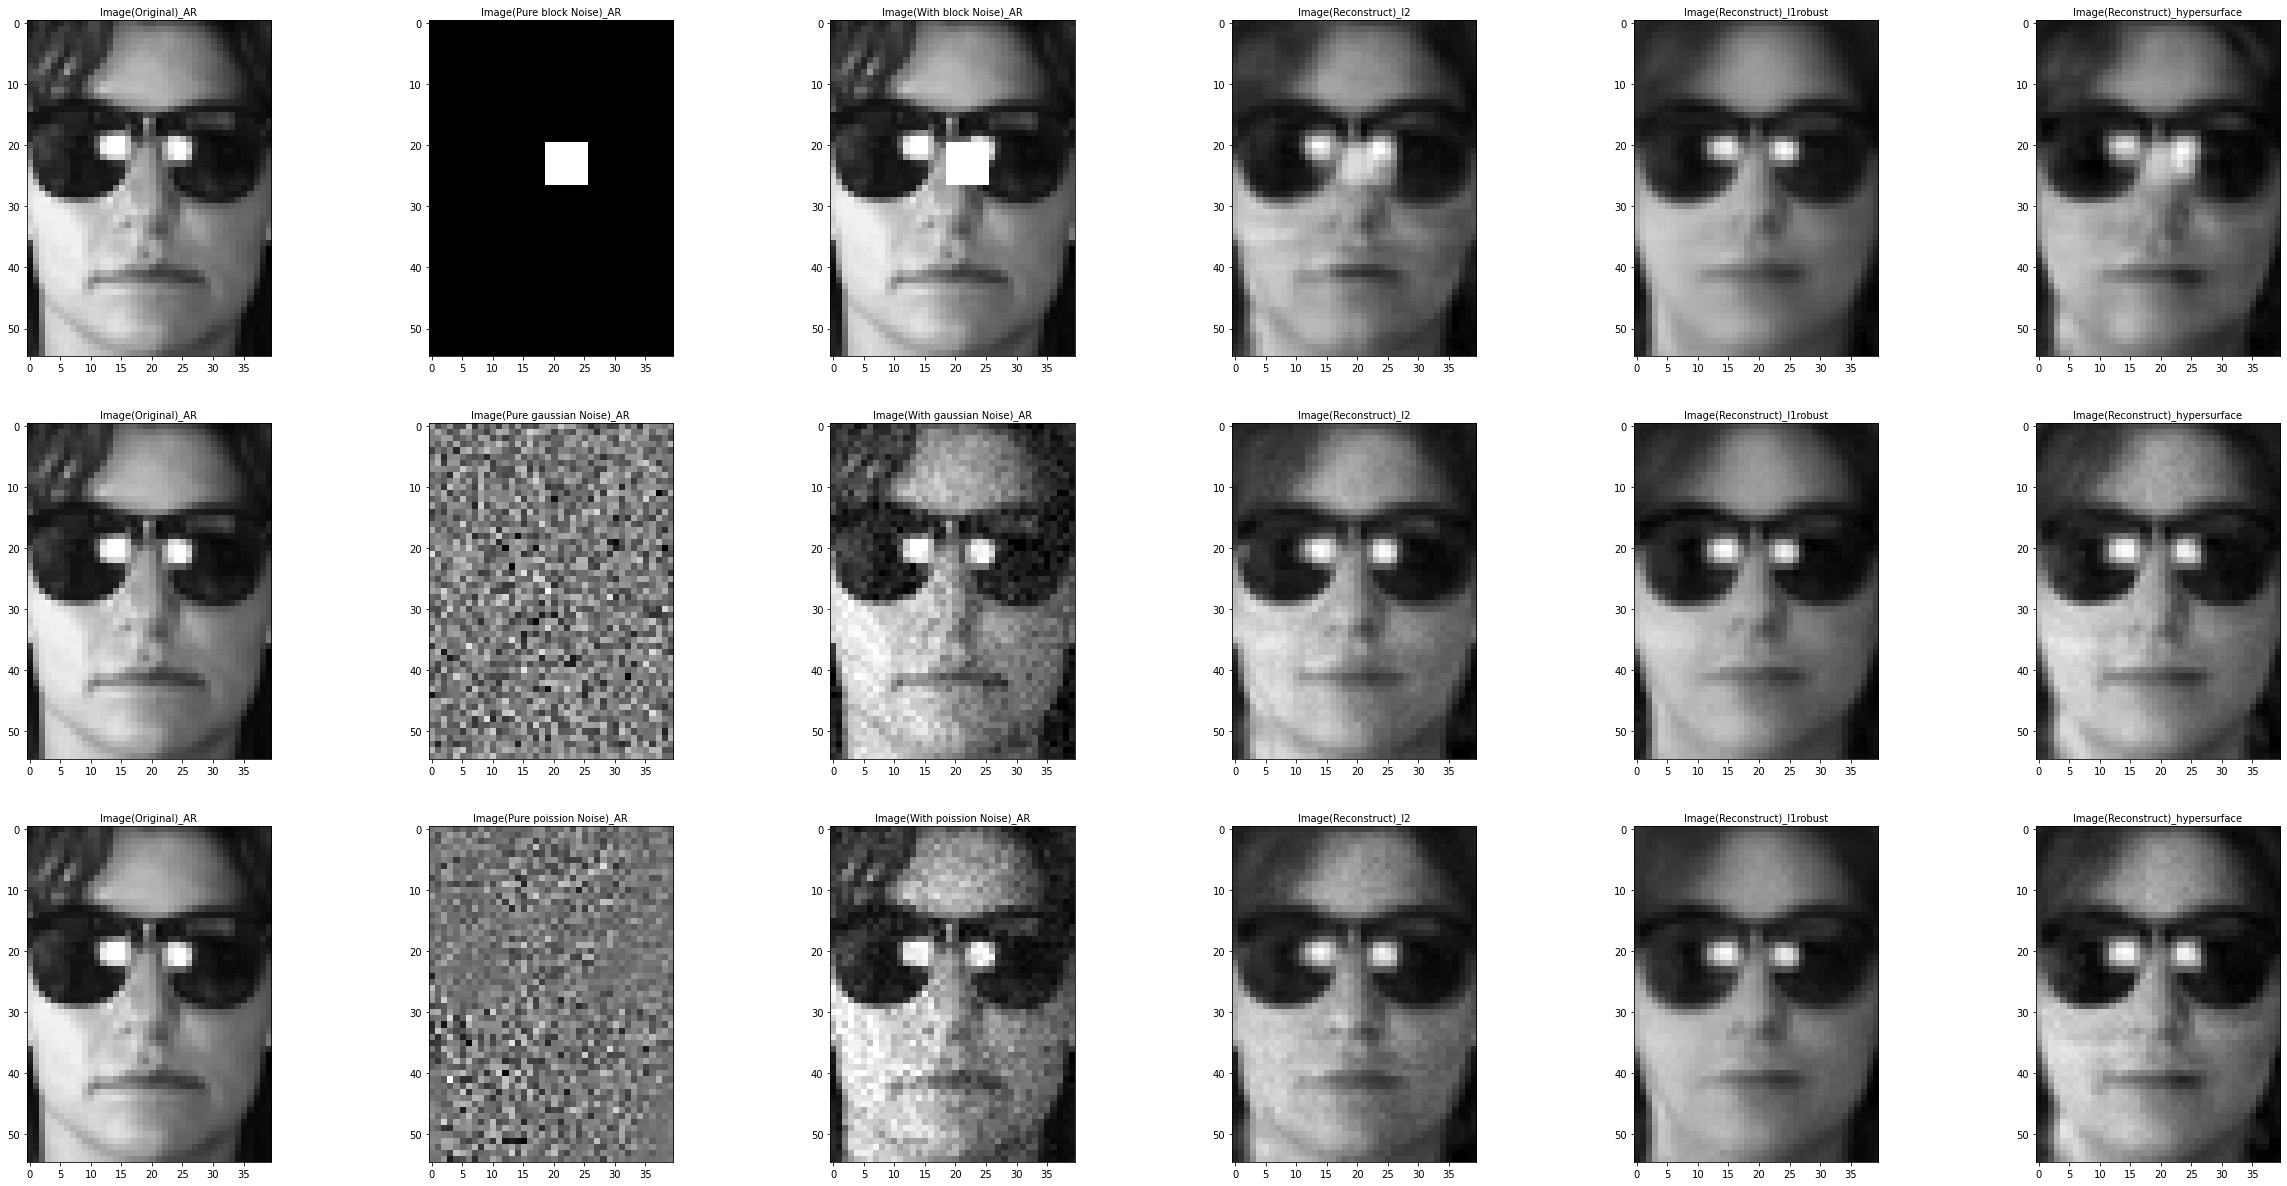

In [ ]:
plot_images(F_results_AR,DATASETS_AR,ind=1077)